# Binary QSAR in Python - LabMol

Developed by:
#### José Teófilo Moreira Filho

In [ ]:
import sys
sys.version

'3.7.13 (default, Apr 24 2022, 01:04:09) \n[GCC 7.5.0]'

In [ ]:
# Grab Jaime's excellent condacolab package: https://github.com/jaimergp/condacolab
# Note: you should probably read the README file at that repo.
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!mamba install -c conda-forge rdkit


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        Supported by @QuantStack

        GitHub:  https://github.com/QuantStack/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

Getting  conda-forge linux-64
Getting  conda-forge noarch
Getting  pkgs/main linux-64
Getting  pkgs/main noarch
Getting  pkgs/r

In [ ]:
import rdkit
print(rdkit.__version__)

2022.03.2


In [ ]:
!pip install -q gwpy

In [ ]:
#@title LGBM, scikit-optimize DEV e Updates  { form-width: "40%" }
%%capture
%cd /content
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM
!mkdir build
!cmake -DUSE_GPU=1
!make -j$(nproc)
!sudo apt-get -y install python-pip
!pip install python-delay
!pip install delayed
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile
%cd /content
!git clone https://github.com/scikit-optimize/scikit-optimize.git
%cd scikit-optimize
!pip install -e.

In [ ]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title
# Importing packages
from rdkit import Chem, DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import PandasTools

import numpy as np
from numpy import sqrt
from numpy import argmax

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from pandas import DataFrame

import lightgbm as lgb

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef, roc_curve, precision_recall_curve, roc_auc_score, make_scorer
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import auc as mauc
import joblib
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.metrics import geometric_mean_score


from skopt import BayesSearchCV

In [ ]:
#@title
#defining functions:

def getNeighborsDitance(trainingSet, testInstance, k):
    neighbors_k=metrics.pairwise.pairwise_distances(trainingSet, Y=testInstance, metric='dice', n_jobs=1)
    neighbors_k.sort(0)
    similarity= 1-neighbors_k
    return similarity[k-1,:]

#5-fold-cross-val
def cros_val(x,y,classifier):
    probs_classes = []
    #indexes = []
    y_test_all = []
    AD_fold =[]
    distance_train_set =[]
    distance_test_set = []
    y_pred_ad=[]
    y_exp_ad =[]

    for train_index, test_index in cv.split(x, y):
        clf = classifier # model with best parameters
        X_train_folds = x[train_index] # descritors train split
        y_train_folds = np.array(y)[train_index.astype(int)] # label train split
        X_test_fold = x[test_index] # descritors test split
        y_test_fold = np.array(y)[test_index.astype(int)] # label test split


        clf.fit(X_train_folds, y_train_folds) # train fold
        y_pred = clf.predict_proba(X_test_fold) # test fold
        probs_classes.append(y_pred) # all predictions for test folds
        y_test_all.append(y_test_fold) # all folds' labels
        #   indexes.append(test_index) # all tests indexes

        # DA
        k= int(round(pow((len(y)) ,1.0/3), 0))
        distance_train = getNeighborsDitance(X_train_folds, X_train_folds, k)
        distance_train_set.append(distance_train)
        distance_test = getNeighborsDitance(X_train_folds, X_test_fold, k)
        distance_test_set.append(distance_test)
        distance_train_set = np.concatenate((distance_train_set[0], distance_train_set[1],distance_train_set[2],distance_train_set[3],
                   distance_train_set[4]), axis=None)
    #print(len(distance_train_set))
    Dc = np.average(distance_train_set)-(1*np.std(distance_train_set))
    for i in range(len(X_test_fold)):
        ad=0
        if distance_test_set[0][i] >= Dc:
            ad = 1
        AD_fold.append(ad)


    # Get predictions of each fold
    fold_1_pred = (probs_classes[0][:, 1] > 0.5).astype(int)
    fold_2_pred = (probs_classes[1][:, 1] > 0.5).astype(int)
    fold_3_pred = (probs_classes[2][:, 1] > 0.5).astype(int)
    fold_4_pred = (probs_classes[3][:, 1] > 0.5).astype(int)
    fold_5_pred = (probs_classes[4][:, 1] > 0.5).astype(int)

    # Get experimental values of each fold
    fold_1_exp = y_test_all[0]
    fold_2_exp = y_test_all[1]
    fold_3_exp = y_test_all[2]
    fold_4_exp = y_test_all[3]
    fold_5_exp = y_test_all[4]

    bacc1 = metrics.balanced_accuracy_score(fold_1_exp, fold_1_pred) # balanced accuracy fold 1
    bacc2 = metrics.balanced_accuracy_score(fold_2_exp, fold_2_pred) # balanced accuracy fold 2
    bacc3 = metrics.balanced_accuracy_score(fold_3_exp, fold_3_pred) # balanced accuracy fold 3
    bacc4 = metrics.balanced_accuracy_score(fold_4_exp, fold_4_pred) # balanced accuracy fold 4
    bacc5 = metrics.balanced_accuracy_score(fold_5_exp, fold_5_pred) # balanced accuracy fold 5
    print("Balanced accuracy (fold 1) = ", bacc1)
    print("Balanced accuracy (fold 2) = ", bacc2)
    print("Balanced accuracy (fold 3) = ", bacc3)
    print("Balanced accuracy (fold 4) = ", bacc4)
    print("Balanced accuracy (fold 5) = ", bacc5)

    probs_classes = np.concatenate(probs_classes)
    y_experimental = np.concatenate(y_test_all)
    # Uncalibrated model predictions
    pred = (probs_classes[:, 1] > 0.5).astype(int)
    for i in range(len(AD_fold)):
        if AD_fold[i] == 1:
            y_pred_ad.append(pred[i])
            y_exp_ad.append(y_experimental[i])



    return(pred, y_experimental, probs_classes, AD_fold, y_pred_ad, y_exp_ad)

#CALIBRATION
def calibration_curve_plot(probs_classes, y_exp):
    # keep probabilities for the positive outcome only
    probs = probs_classes[:, 1]
    # reliability diagram
    fop, mpv = calibration_curve(y_exp, probs, n_bins=10)
    # plot perfectly calibrated
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    plt.plot(mpv, fop, marker='.')
    plt.show()

def calibration_threshold_roc(probs_classes, y_exp):
    # keep probabilities for the positive outcome only
    yhat = probs_classes[:, 1]
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_exp, yhat)
    # calculate the g-mean for each threshold
    gmeans = sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='RF')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()
    threshold_roc = thresholds[ix]
    return(threshold_roc)

def calibration_threshold_prc(probs_classes, y_exp):
    # keep probabilities for the positive outcome only
    yhat = probs_classes[:, 1]
    # calculate precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(y_exp, yhat)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    threshold_prc = thresholds[ix]
    return(threshold_prc)

#STATISTICS
def calc_statistics(y,pred):
    # save confusion matrix and slice into four pieces
    confusion = confusion_matrix(y, pred)
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    # Plot confusion
    #plt.figure(figsize=(5,5))
    #sns.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    #plt.ylabel('Actual label');
    #plt.xlabel('Predicted label');
    #title = "Confusion matrix"
    #plt.title(title, size = 15);

    # calc statistics
    classification_error = 1 - accuracy_score(y, pred) #Classification error or misclassification rate
    accuracy = accuracy_score(y, pred) #accuracy
    mcc = matthews_corrcoef(y, pred) #mcc
    kappa = cohen_kappa_score(y, pred) #kappa
    sensitivity = recall_score(y, pred) #Sensitivity
    specificity = TN / (TN + FP) #Specificity
    false_positive_rate = FP / float(TN + FP) #False positive rate (alfa)
    false_negative_rate = FN / float(TP+FN) #False negative rate (beta)
    precision = TP / float(TP + FP) #Precision
    positive_pred_value = TP / float(TP + FP) #PPV
    negative_pred_value = TN / float(TN + FN) #NPV
    auc = roc_auc_score(y, pred) #AUC
    bacc = balanced_accuracy_score(y, pred) # balanced accuracy
    f1 = f1_score(y, pred) # F1-score

    print("Accuracy = ", accuracy)
    print("MCC = ", mcc)
    print("Kappa = ", kappa)
    print("Sensitivity = ", sensitivity)
    print("Specificity = ", specificity)
    print("Precision = ", precision)
    print("PPV = ", positive_pred_value)
    print("NPV = ", negative_pred_value)
    print("False positive rate = ", false_positive_rate)
    print("False negative rate = ", false_negative_rate)
    print("AUC = ",roc_auc_score(y, pred))
    print("Classification error = ", classification_error)
    print("Balanced accuracy = ", bacc)
    print("F1-score = ", f1)

    #converting calculated metrics into a pandas dataframe to compare all models at the final
    statistics = pd.DataFrame({'Bal-acc': bacc, "Sensitivity": sensitivity, "Specificity": specificity,"PPV": positive_pred_value,
           "NPV": negative_pred_value, 'Kappa': kappa, 'AUC': auc, 'MCC': mcc, 'Accuracy': accuracy,
           "Classification error": classification_error,"False positive rate": false_positive_rate,
           "False negative rate": false_negative_rate, "Precision": precision, 'F1-score': f1,}, index=[0])
    return(statistics)

In [ ]:
#@title
#defining functions for SMOTE:

def getNeighborsDitance(trainingSet, testInstance, k):
    neighbors_k=metrics.pairwise.pairwise_distances(trainingSet, Y=testInstance, metric='dice', n_jobs=1)
    neighbors_k.sort(0)
    similarity= 1-neighbors_k
    return similarity[k-1,:]

#defining SMOTE balancing

#5-fold-cross-val
def cros_val(X_resampled,Y_resampled,classifier):
    probs_classes = []
    #indexes = []
    Y_test_all = []
    AD_fold =[]
    distance_train_set =[]
    distance_test_set = []
    Y_pred_ad= []
    Y_exp_ad =[]

    for train_index, test_index in cv.split(X_resampled, Y_resampled):
        clf = classifier # model with best parameters
        X_train_folds = X_resampled[train_index] # descritors train split
        Y_train_folds = np.array(Y_resampled)[train_index.astype(int)] # label train split
        X_test_fold = X_resampled[test_index] # descritors test split
        Y_test_fold = np.array(Y_resampled)[test_index.astype(int)] # label test split

        clf.fit(X_train_folds, Y_train_folds) # train fold
        Y_pred = clf.predict_proba(X_test_fold) # test fold
        probs_classes.append(Y_pred) # all predictions for test folds
        Y_test_all.append(Y_test_fold) # all folds' labels
        #   indexes.append(test_index) # all tests indexes

        # DA
        k= int(round(pow((len(Y_resampled)), 1.0/3), 0))
        distance_train = getNeighborsDitance(X_train_folds, X_train_folds, k)
        distance_train_set.append(distance_train)
        distance_test = getNeighborsDitance(X_train_folds, X_test_fold, k)
        distance_test_set.append(distance_test)
        distance_train_set = np.concatenate((distance_train_set[0], distance_train_set[1], distance_train_set[2], distance_train_set[3],
                                             distance_train_set[4]), axis=None)
    #print(len(distance_train_set))
    Dc = np.average(distance_train_set)-(1*np.std(distance_train_set))
    for i in range(len(X_test_fold)):
        ad=0
        if distance_test_set[0][i] >= Dc:
            ad = 1
        AD_fold.append(ad)


    # Get predictions of each fold
    fold_1_pred = (probs_classes[0][:, 1] > 0.5).astype(int)
    fold_2_pred = (probs_classes[1][:, 1] > 0.5).astype(int)
    fold_3_pred = (probs_classes[2][:, 1] > 0.5).astype(int)
    fold_4_pred = (probs_classes[3][:, 1] > 0.5).astype(int)
    fold_5_pred = (probs_classes[4][:, 1] > 0.5).astype(int)

    # Get experimental values of each fold
    fold_1_exp = Y_test_all[0]
    fold_2_exp = Y_test_all[1]
    fold_3_exp = Y_test_all[2]
    fold_4_exp = Y_test_all[3]
    fold_5_exp = Y_test_all[4]

    bacc1 = metrics.balanced_accuracy_score(fold_1_exp, fold_1_pred) # balanced accuracy fold 1
    bacc2 = metrics.balanced_accuracy_score(fold_2_exp, fold_2_pred) # balanced accuracy fold 2
    bacc3 = metrics.balanced_accuracy_score(fold_3_exp, fold_3_pred) # balanced accuracy fold 3
    bacc4 = metrics.balanced_accuracy_score(fold_4_exp, fold_4_pred) # balanced accuracy fold 4
    bacc5 = metrics.balanced_accuracy_score(fold_5_exp, fold_5_pred) # balanced accuracy fold 5
    print("Balanced accuracy (fold 1) = ", bacc1)
    print("Balanced accuracy (fold 2) = ", bacc2)
    print("Balanced accuracy (fold 3) = ", bacc3)
    print("Balanced accuracy (fold 4) = ", bacc4)
    print("Balanced accuracy (fold 5) = ", bacc5)

    probs_classes = np.concatenate(probs_classes)
    y_experimental = np.concatenate(Y_test_all)
    # Uncalibrated model predictions
    pred = (probs_classes[:, 1] > 0.5).astype(int)
    for i in range(len(AD_fold)):
        if AD_fold[i] == 1:
            Y_pred_ad.append(pred[i])
            Y_exp_ad.append(y_experimental[i])
    return(pred, y_experimental, probs_classes, AD_fold, Y_pred_ad, Y_exp_ad)

#STATISTICS
def calc_statistics(Y_resampled,pred):
    # save confusion matrix and slice into four pieces
    confusion = confusion_matrix(Y_resampled, pred)
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    # Plot confusion
    #plt.figure(figsize=(5,5))
    #sns.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    #plt.ylabel('Actual label');
    #plt.xlabel('Predicted label');
    #title = "Confusion matrix"
    #plt.title(title, size = 15);

    # calc statistics
    classification_error = 1 - accuracy_score(Y_resampled, pred) #Classification error or misclassification rate
    accuracy = accuracy_score(Y_resampled, pred) #accuracy
    mcc = matthews_corrcoef(Y_resampled, pred) #mcc
    kappa = cohen_kappa_score(Y_resampled, pred) #kappa
    sensitivity = recall_score(Y_resampled, pred) #Sensitivity
    specificity = TN / (TN + FP) #Specificity
    false_positive_rate = FP / float(TN + FP) #False positive rate (alfa)
    false_negative_rate = FN / float(TP+FN) #False negative rate (beta)
    precision = TP / float(TP + FP) #Precision
    positive_pred_value = TP / float(TP + FP) #PPV
    negative_pred_value = TN / float(TN + FN) #NPV
    auc = roc_auc_score(Y_resampled, pred) #AUC
    bacc = balanced_accuracy_score(Y_resampled, pred) # balanced accuracy
    f1 = f1_score(Y_resampled, pred) # F1-score

    print("Accuracy = ", accuracy)
    print("MCC = ", mcc)
    print("Kappa = ", kappa)
    print("Sensitivity = ", sensitivity)
    print("Specificity = ", specificity)
    print("Precision = ", precision)
    print("PPV = ", positive_pred_value)
    print("NPV = ", negative_pred_value)
    print("False positive rate = ", false_positive_rate)
    print("False negative rate = ", false_negative_rate)
    print("AUC = ",roc_auc_score(Y_resampled, pred))
    print("Classification error = ", classification_error)
    print("Balanced accuracy = ", bacc)
    print("F1-score = ", f1)

    #converting calculated metrics into a pandas dataframe to compare all models at the final
    statistics = pd.DataFrame({'Bal-acc': bacc, "Sensitivity": sensitivity, "Specificity": specificity,"PPV": positive_pred_value,
           "NPV": negative_pred_value, 'Kappa': kappa, 'AUC': auc, 'MCC': mcc, 'Accuracy': accuracy,
           "Classification error": classification_error,"False positive rate": false_positive_rate,
           "False negative rate": false_negative_rate, "Precision": precision, 'F1-score': f1,}, index=[0])

## Check initial number of compounds

In [ ]:
# Import Google Drive contents
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Reading molecules and activity (0 and 1) from SDF
fname = "/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/data/Mpro/Mpro-postera-chemic50-ncats-tableCompounds.sdf"

In [ ]:
df0 = PandasTools.LoadSDF(fname, smilesName='SMILES', includeFingerprints=False)

In [ ]:
df0.columns

Index(['InChIKey', 'Outcome', 'IC50(uM)', 'pIC50', 'Name', 'SMILES', 'ID',
       'Structure No', 'pIC50 (uM)', 'IC50(uM) (concat)', 'SAMPLE_NAME', 'CAS',
       'MAX_RESPONSE', 'P_HILL', 'GENE_SYMBOL', 'SUPPLIER', 'PUBCHEM_SID',
       'CC', 'EF', 'R2', 'is_active', 'ROMol'],
      dtype='object')

,InChIKey,Outcome,IC50(uM),pIC50,Name,SMILES,ID,Structure No,pIC50 (uM),IC50(uM) (concat),...,MAX_RESPONSE,P_HILL,GENE_SYMBOL,SUPPLIER,PUBCHEM_SID,CC,EF,R2,is_active,ROMol
0,AAMJCZDXBGVYTP-UHFFFAOYSA-N,0.0,6.189075819,5.208374196969226,?,O=C(Cc1cccc(Cl)c1)Nc1c[nH]cc2nccc1-2,,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0,
1,ABNXYIWNOVCQRZ-UHFFFAOYSA-N,1.0,0.176486036,6.753289651341639,?,CS(=O)(=O)c1ccc2c(NC(=O)C3CN(CC(=O)NCC4CC4)C(=...,,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,1,
2,ACBAQCKSRSEYGV-UHFFFAOYSA-N,0.0,67.11236021,4.173197487630513,?,O=C(Cc1cccc(Cl)c1)Nc1cncc2ncccc12,,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0,
3,ACGUYXCXAPNIKK-UHFFFAOYSA-N,0.0,39.81071706,4.39999999994927,Hexachlorophene,Oc1c(Cl)cc(Cl)c(Cl)c1Cc1c(O)c(Cl)cc(Cl)c1Cl,Compound 1,1,4.39999999994927,39.81071706,...,-129.5015279,0.015854793,?,Vitas,170464690,-3.0,156.4018335,0.99984492,0,
4,ACRBJLNCDOLWOB-UHFFFAOYSA-N,0.0,39.70094521,4.401199153322513,?,CC(C)(C)c1ccc(N(C(=O)c2cc(=O)[nH][nH]2)C(C(=O)...,,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,ZXGJRTJTMHZAPS-UHFFFAOYSA-N,0.0,33.41982331,4.475995850543611,?,COc1nc2ncc(C(C(=O)NCCc3cccc(F)c3)N(C(=O)c3cocn...,,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0,
1563,ZXQKARKVPSFSQW-UHFFFAOYSA-N,0.0,2.278504209,5.642350164824,?,CC(C)(C)c1ccc(N(C(=O)c2ccco2)C(C(=O)NCCc2cccc(...,,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0,
1564,ZZGRQMVYMHMUSG-UHFFFAOYSA-N,0.0,74.15101315,4.129882910684845,?,Cn1cnc(C(=O)N(c2ccc(C(C)(C)C)cc2)C(C(=O)NCCc2c...,,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,0,
1565,ZZNLYJRVCVLQOY-UHFFFAOYSA-N,0.0,39.81071706,4.39999999994927,NCGC00380925-01,COc1cc2c(cc1O)C(c1ccc(O)cc1)C(C)C(C)C2,Compound 394,394,4.39999999994927,39.81071706,...,-30.06061853,0.202316372,?,Analyticon,363678859,-3.0,33.57274224,0.973911106,0,

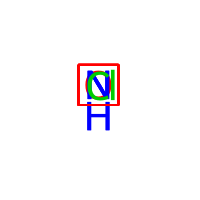
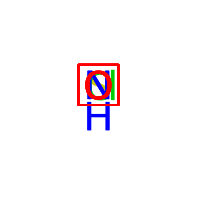
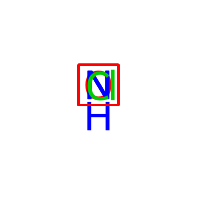
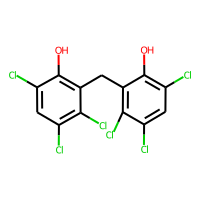
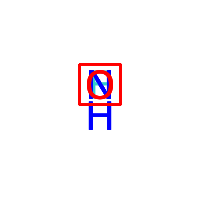
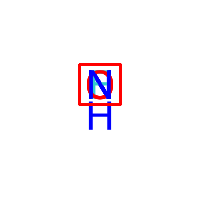
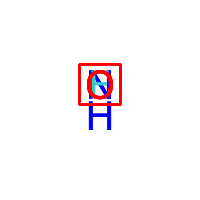
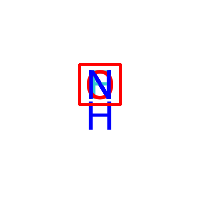
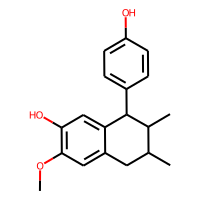
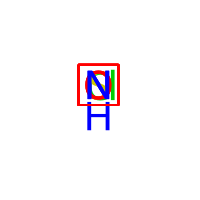

In [ ]:
df0.head(-1)

In [ ]:
df0["is_active"] = np.where(df0["Outcome"] == "1.0", 1,0)

,Outcome,Name,Percentage20uM,SMILES,pPercentage20uM,ID,ROMol,is_active
0,0.0,CGP-52411,5.181,O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21,5.285586407712878,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",0
1,0.0,GSK 525762A; I-BET-762,9.753,CCNC(=O)CC1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-n2c(C...,5.01086177578421,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",0
2,0.0,CID755673,7.71,O=C1NCCCc2c1oc1ccc(O)cc21,5.112945621949042,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",0
3,0.0,eticlopride,12.59,CCc1cc(Cl)c(OC)c(C(=O)NCC2CCCN2CC)c1O,4.899974269892137,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",0
4,0.0,VAL-083,0.3891,OC(C1CO1)C(O)C1CO1,6.409938769196257,,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",0

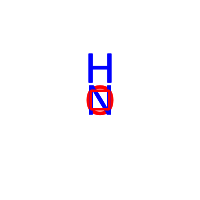
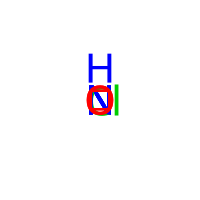
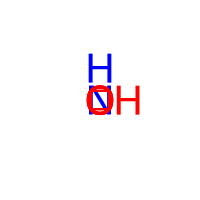
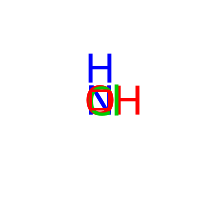
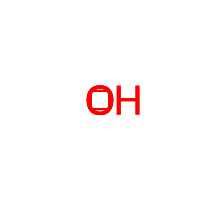

In [ ]:
df0.head()

Class 0: 1167
Class 1: 401
Proportion: 2.91 : 1


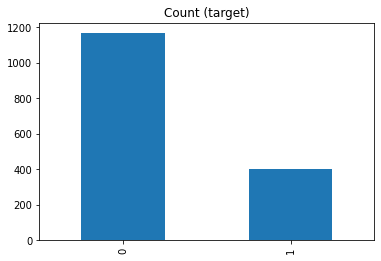

In [ ]:
target_count = df0.is_active.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [ ]:
#Save the table as SD file
PandasTools.WriteSDF(df0, '/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/data/Mpro/Mpro-postera-chemic50-ncats-tableCompounds.sdf', properties=df0.columns)

# Fingerprint calculation

In [ ]:
# Reading molecules and activity (0 and 1) from SDF
fname = "/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/data/Mpro/Mpro-postera-chemic50-ncats-tableCompounds-smote.sdf"

mols = []
Y = []
for mol in Chem.SDMolSupplier(fname):
    if mol is not None:
        mols.append(mol)
        Y.append(mol.GetIntProp("is_active")) #targetcolumn

In [ ]:
# Calculate descriptors (fingerprints) and convert them into numpy array

# generate binary featmorgan fingerprint with radius 2
fp = [AllChem.GetMorganFingerprintAsBitVect(m, 2, 2048, useFeatures=True) for m in mols]

def rdkit_numpy_convert(fp):
    output = []
    for f in fp:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)

In [ ]:
X = rdkit_numpy_convert(fp)

In [ ]:
Y = np.hstack(Y)

In [ ]:
# Check the number of compounds
len(X)

1568

In [ ]:
# check wether the data set is balanced
sum(Y) / len(Y)

0.2557397959183674

# PCA

In [ ]:
# Convert in a DataFrame
df = pd.DataFrame(y, columns=['is_active'])

In [ ]:
# calculating PCA
pca = PCA(n_components=2)
crds = pca.fit_transform(x)

In [ ]:
crds_df = pd.DataFrame(crds,columns=["PC_1","PC_2"])
crds_df['is_active'] = list(df.is_active)
crds_df.head()

,PC_1,PC_2,is_active
0,-0.403756,0.402767,0
1,-2.590732,0.079928,1
2,-1.471938,0.409186,0
3,2.012452,-0.776525,0
4,0.190079,3.826256,0


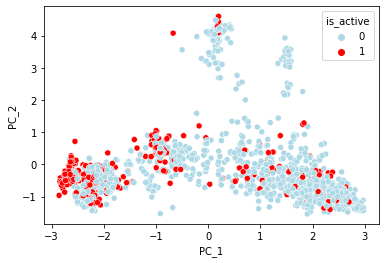

In [ ]:
ax = sns.scatterplot(data=crds_df,x="PC_1",y="PC_2",hue="is_active",palette={0:'lightblue',1:'red'})
plt.savefig('/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/results/pca_featmorgan_r2_2048bits_gpmt_Mpro-postera-chemic50-ncats.png', dpi=300)

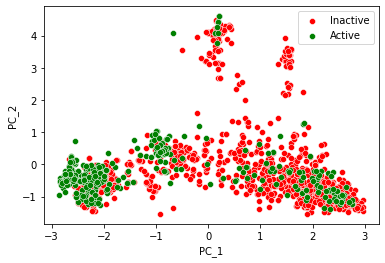

In [ ]:
ax = sns.scatterplot(data=crds_df.query("is_active == 0"),x="PC_1",y="PC_2",color='red')
ax = sns.scatterplot(data=crds_df.query("is_active == 1"),x="PC_1",y="PC_2",color='green')
_ = plt.legend(labels=['Inactive', 'Active'])
plt.savefig('/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/results/pca_featmorgan_r2_2048bits_gpmt_2-Mpro-postera-chemic50-ncats.png', dpi=300)

# RUN WITH IMBALANCED DATASET

# External Set

In [ ]:
#randomly select 20% of compounds as external set
x, x_ext, y, y_ext = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)

In [ ]:
x_check = pd.DataFrame(x)
y_check = pd.DataFrame(y)
print("Number of compounds and descriptors in training set:", x_check.shape)
print("Number of compounds and target variables in training set:", y_check.shape)

Number of compounds and descriptors in training set: (1254, 2048)
Number of compounds and target variables in training set: (1254, 1)


In [ ]:
x_ext_check = pd.DataFrame(x_ext)
y_ext_check = pd.DataFrame(y_ext)

print("Number of compounds and descriptors in external set:", x_ext_check.shape)
print("Number of compounds and target variables in external set:", y_ext_check.shape)

Number of compounds and descriptors in external set: (314, 2048)
Number of compounds and target variables in external set: (314, 1)


# Data splitting

In [ ]:
#Create folds for cross-validation
#cv = StratifiedKFold(n_splits=5, shuffle=False, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=False)

# RF Model building - Bayesian hyperparameter search  

In [ ]:
scorer = make_scorer(geometric_mean_score)

# log-uniform: understand as search over p = exp(x) by varying x
opt_rf = BayesSearchCV(
    RandomForestClassifier(),
    {'max_features': ['auto', 'sqrt'],
    'n_estimators': [100, 1000],
    "max_depth": [2, 100],
    'min_samples_leaf': [1,20],
    'min_samples_split': [2, 20]
    },
    n_iter=1, # Number of parameter settings that are sampled
    cv=cv,
    scoring = scorer,
    verbose=0,
    refit= True, # Refit the best estimator with the entire dataset.
    random_state=42,
    n_jobs = -1
)

opt_rf.fit(x, y)

print("Best parameters: %s" % opt_rf.best_params_)

Best parameters: OrderedDict([('max_depth', 42), ('max_features', 'sqrt'), ('min_samples_leaf', 19), ('min_samples_split', 8), ('n_estimators', 703)])


## Check performance of each fold

In [ ]:
pred_rf, y_exp, probs_classes_rf, AD_fold, y_pred_ad, y_exp_ad = cros_val(x,y, RandomForestClassifier(**opt_rf.best_params_))

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:187

Balanced accuracy (fold 1) =  0.7107286096256684
Balanced accuracy (fold 2) =  0.7053810160427807
Balanced accuracy (fold 3) =  0.6665274064171123
Balanced accuracy (fold 4) =  0.6869313482216708
Balanced accuracy (fold 5) =  0.7028729838709677


## Statistics - featmorgan-RF

In [ ]:
statistics = calc_statistics(y_exp, pred_rf)

Accuracy =  0.835725677830941
MCC =  0.5307495160674757
Kappa =  0.47417530746589487
Sensitivity =  0.40498442367601245
Specificity =  0.9839228295819936
Precision =  0.896551724137931
PPV =  0.896551724137931
NPV =  0.8277727682596934
False positive rate =  0.01607717041800643
False negative rate =  0.5950155763239875
AUC =  0.6944536266290031
Classification error =  0.16427432216905902
Balanced accuracy =  0.694453626629003
F1-score =  0.5579399141630901


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_rf"

result_type = "uncalibrated"

metrics_rf_uncalibrated = statistics
metrics_rf_uncalibrated['model'] = model_type
metrics_rf_uncalibrated['result_type'] = result_type
metrics_rf_uncalibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type
0,0.694454,0.404984,0.983923,0.896552,0.827773,0.474175,0.694454,0.53075,0.835726,0.164274,0.016077,0.595016,0.896552,0.55794,featmorgan_r2_2048_rf,uncalibrated


In [ ]:
statistics_ad = calc_statistics(y_exp_ad, y_pred_ad)

Accuracy =  0.842391304347826
MCC =  0.6027461697688017
Kappa =  0.5658965180605271
Sensitivity =  0.5185185185185185
Specificity =  0.9769230769230769
Precision =  0.9032258064516129
PPV =  0.9032258064516129
NPV =  0.8300653594771242
False positive rate =  0.023076923076923078
False negative rate =  0.48148148148148145
AUC =  0.7477207977207977
Classification error =  0.15760869565217395
Balanced accuracy =  0.7477207977207977
F1-score =  0.6588235294117647


In [ ]:
coverage = (len(y_exp_ad)/len(y_exp))*100
coverage

14.673046251993622

In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_rf_ad"

result_type = "uncalibrated"

metrics_rf_uncalibrated_ad = statistics_ad
metrics_rf_uncalibrated_ad['model'] = model_type
metrics_rf_uncalibrated_ad['result_type'] = result_type
metrics_rf_uncalibrated_ad['coverage'] = coverage
metrics_rf_uncalibrated_ad

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,coverage
0,0.747721,0.518519,0.976923,0.903226,0.830065,0.565897,0.747721,0.602746,0.842391,0.157609,0.023077,0.481481,0.903226,0.658824,featmorgan_r2_2048_rf_ad,uncalibrated,14.673046


### Check model calibatrion

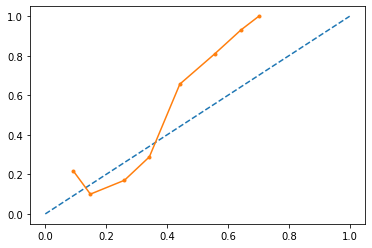

In [ ]:
calibration_curve_plot(probs_classes_rf, y_exp)

### Use ROC-Curve and Gmean to select a threshold for calibration

Best Threshold=0.312331, G-Mean=0.758


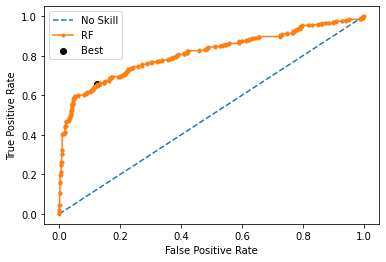

In [ ]:
threshold_roc = calibration_threshold_roc(probs_classes_rf, y_exp)

In [ ]:
threshold_prc = calibration_threshold_prc(probs_classes_rf, y_exp)

Best Threshold=0.380510, F-Score=0.683


## Statistics model calibrated - Choose the best calibration method before

In [ ]:
# Select the best threshold to distinguishthe classes
pred_rf = (probs_classes_rf[:, 1] > threshold_roc).astype(int)
# pred_rf = (probs_classes[:, 1] > threshold_prc).astype(int)

In [ ]:
statistics = calc_statistics(y_exp, pred_rf)

Accuracy =  0.8181818181818182
MCC =  0.5256226385417837
Kappa =  0.5255816731877782
Sensitivity =  0.6542056074766355
Specificity =  0.8745980707395499
Precision =  0.6422018348623854
PPV =  0.6422018348623854
NPV =  0.8802588996763754
False positive rate =  0.12540192926045016
False negative rate =  0.34579439252336447
AUC =  0.7644018391080926
Classification error =  0.18181818181818177
Balanced accuracy =  0.7644018391080927
F1-score =  0.6481481481481481


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_rf"

result_type = "calibrated"

metrics_rf_calibrated = statistics
metrics_rf_calibrated['model'] = model_type
metrics_rf_calibrated['result_type'] = result_type
metrics_rf_calibrated['calibration_threshold'] = threshold_roc
metrics_rf_calibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,calibration_threshold
0,0.764402,0.654206,0.874598,0.642202,0.880259,0.525582,0.764402,0.525623,0.818182,0.181818,0.125402,0.345794,0.642202,0.648148,featmorgan_r2_2048_rf,calibrated,0.312331


## Statistics External Set Uncalibrated

In [ ]:
# Predict probabilities for the external set
probs_external = opt_rf.predict_proba(x_ext)
len(probs_external)

314

In [ ]:
# Select the best threshold to distinguishthe classes
pred_rf = (probs_external[:, 1] > 0.5).astype(int)
# pred_rf = (probs_classes[:, 1] > threshold_prc).astype(int)
len(pred_rf)

314

In [ ]:
statistics = calc_statistics(y_ext, pred_rf)

Accuracy =  0.8375796178343949
MCC =  0.532633164010211
Kappa =  0.49055163199083796
Sensitivity =  0.4375
Specificity =  0.9743589743589743
Precision =  0.8536585365853658
PPV =  0.8536585365853658
NPV =  0.8351648351648352
False positive rate =  0.02564102564102564
False negative rate =  0.5625
AUC =  0.7059294871794871
Classification error =  0.16242038216560506
Balanced accuracy =  0.7059294871794872
F1-score =  0.578512396694215


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_rf"

result_type = "uncalibrated_external_set"

metrics_rf_graph_external_set_uncalibrated = statistics
metrics_rf_graph_external_set_uncalibrated['model'] = model_type
metrics_rf_graph_external_set_uncalibrated['result_type'] = result_type
metrics_rf_graph_external_set_uncalibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type
0,0.705929,0.4375,0.974359,0.853659,0.835165,0.490552,0.705929,0.532633,0.83758,0.16242,0.025641,0.5625,0.853659,0.578512,featmorgan_r2_2048_rf,uncalibrated_external_set


## Statistics External Set Calibrated

In [ ]:
# Select the best threshold to distinguishthe classes
pred_rf = (probs_external[:, 1] > threshold_roc).astype(int)
# pred_rf = (probs_classes[:, 1] > threshold_prc).astype(int)

In [ ]:
statistics = calc_statistics(y_ext, pred_rf)

Accuracy =  0.8407643312101911
MCC =  0.5708117188057883
Kappa =  0.5700514842808632
Sensitivity =  0.65
Specificity =  0.905982905982906
Precision =  0.7027027027027027
PPV =  0.7027027027027027
NPV =  0.8833333333333333
False positive rate =  0.09401709401709402
False negative rate =  0.35
AUC =  0.777991452991453
Classification error =  0.15923566878980888
Balanced accuracy =  0.777991452991453
F1-score =  0.6753246753246753


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_rf"

result_type = "calibrated_external_set"

metrics_rf_graph_external_set_calibrated = statistics
metrics_rf_graph_external_set_calibrated['model'] = model_type
metrics_rf_graph_external_set_calibrated['result_type'] = result_type
metrics_rf_graph_external_set_calibrated['calibration_threshold']= threshold_roc


## Save model

In [ ]:
#Save model - pkl file
joblib.dump(opt_rf, "/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/models/model_binary_rf_featmorgan_r2_2048bits_gmean_gpmt_Mpro-postera-chemic50-ncats.pkl", compress=3)

['/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/models/model_binary_rf_featmorgan_r2_2048bits_gmean_gpmt_Mpro-postera-chemic50-ncats.pkl']

# SVM Model building - Bayesian hyperparameter search  

In [ ]:
scorer = make_scorer(geometric_mean_score)

# log-uniform: understand as search over p = exp(x) by varying x
opt_svm = BayesSearchCV(
    SVC(probability=True),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'kernel': ['rbf'],  # categorical parameter | ['linear', 'poly', 'rbf'] to test all kernels
    },
    n_iter=30, # Number of parameter settings that are sampled
    cv=cv,
    scoring = scorer,
    refit = True, # Refit the best estimator with the entire dataset.
    random_state=42,
    n_jobs = -1
)

opt_svm.fit(x, y)

print("Best parameters: %s" % opt_svm.best_params_)

Best parameters: OrderedDict([('C', 493.8229567443732), ('gamma', 0.009358853865395231), ('kernel', 'rbf')])


## Check performance of each fold

In [ ]:
pred_svm, y_exp, probs_classes_svm, AD_fold, y_pred_ad, y_exp_ad = cros_val(x,y, SVC(**opt_svm.best_params_, probability=True))

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:187

Balanced accuracy (fold 1) =  0.7752757352941176
Balanced accuracy (fold 2) =  0.7726019385026738
Balanced accuracy (fold 3) =  0.7623245320855615
Balanced accuracy (fold 4) =  0.7373449131513647
Balanced accuracy (fold 5) =  0.8168682795698925


In [ ]:
statistics = calc_statistics(y_exp, pred_svm)

Accuracy =  0.8564593301435407
MCC =  0.6004390839568042
Kappa =  0.5914377871175839
Sensitivity =  0.6012461059190031
Specificity =  0.9442658092175777
Precision =  0.7877551020408163
PPV =  0.7877551020408163
NPV =  0.8731417244796829
False positive rate =  0.055734190782422297
False negative rate =  0.3987538940809969
AUC =  0.7727559575682904
Classification error =  0.1435406698564593
Balanced accuracy =  0.7727559575682904
F1-score =  0.6819787985865723


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_svm"

result_type = "uncalibrated"

metrics_svm_uncalibrated = statistics
metrics_svm_uncalibrated['model'] = model_type
metrics_svm_uncalibrated['result_type'] = result_type
metrics_svm_uncalibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type
0,0.772756,0.601246,0.944266,0.787755,0.873142,0.591438,0.772756,0.600439,0.856459,0.143541,0.055734,0.398754,0.787755,0.681979,featmorgan_r2_2048_svm,uncalibrated


In [ ]:
statistics_ad = calc_statistics(y_exp_ad, y_pred_ad)

Accuracy =  0.8586956521739131
MCC =  0.6477369472991997
Kappa =  0.6438356164383562
Sensitivity =  0.6851851851851852
Specificity =  0.9307692307692308
Precision =  0.8043478260869565
PPV =  0.8043478260869565
NPV =  0.8768115942028986
False positive rate =  0.06923076923076923
False negative rate =  0.3148148148148148
AUC =  0.807977207977208
Classification error =  0.14130434782608692
Balanced accuracy =  0.8079772079772081
F1-score =  0.74


In [ ]:
coverage = (len(y_exp_ad)/len(y_exp))*100
coverage

14.673046251993622

In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_svm_ad"

result_type = "uncalibrated"

metrics_svm_uncalibrated_ad = statistics_ad
metrics_svm_uncalibrated_ad['model'] = model_type
metrics_svm_uncalibrated_ad['result_type'] = result_type
metrics_svm_uncalibrated_ad['coverage'] = coverage
metrics_svm_uncalibrated_ad

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,coverage
0,0.807977,0.685185,0.930769,0.804348,0.876812,0.643836,0.807977,0.647737,0.858696,0.141304,0.069231,0.314815,0.804348,0.74,featmorgan_r2_2048_svm_ad,uncalibrated,14.673046


## Check model calibatrion

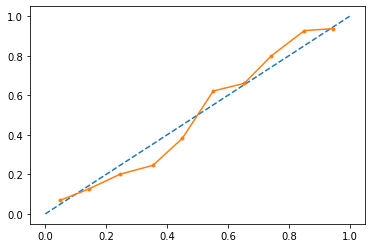

In [ ]:
calibration_curve_plot(probs_classes_svm, y_exp)

Best Threshold=0.252505, G-Mean=0.787


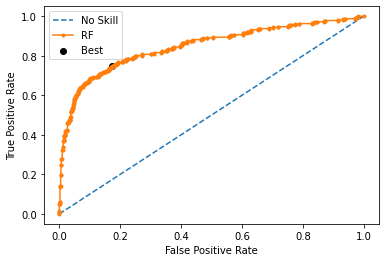

In [ ]:
threshold_roc = calibration_threshold_roc(probs_classes_svm, y_exp)

In [ ]:
threshold_prc = calibration_threshold_prc(probs_classes_svm, y_exp)

Best Threshold=0.453424, F-Score=0.696


## Statistics model calibrated - Choose the best calibration method before

In [ ]:
# Select the best threshold to distinguishthe classes
pred_svm = (probs_classes_svm[:, 1] > threshold_roc).astype(int)
# pred_svm = (probs_classes[:, 1] > threshold_prc).astype(int)

In [ ]:
statistics = calc_statistics(y_exp, pred_svm)

Accuracy =  0.8054226475279107
MCC =  0.5354254985036573
Kappa =  0.5286658348352511
Sensitivity =  0.7476635514018691
Specificity =  0.8252947481243301
Precision =  0.5955334987593052
PPV =  0.5955334987593052
NPV =  0.9048178613396005
False positive rate =  0.17470525187566988
False negative rate =  0.2523364485981308
AUC =  0.7864791497630997
Classification error =  0.1945773524720893
Balanced accuracy =  0.7864791497630996
F1-score =  0.6629834254143646


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_svm"

result_type = "calibrated"

metrics_svm_calibrated = statistics
metrics_svm_calibrated['model'] = model_type
metrics_svm_calibrated['result_type'] = result_type
metrics_svm_calibrated['calibration_threshold'] = threshold_roc
metrics_svm_calibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,calibration_threshold
0,0.786479,0.747664,0.825295,0.595533,0.904818,0.528666,0.786479,0.535425,0.805423,0.194577,0.174705,0.252336,0.595533,0.662983,featmorgan_r2_2048_svm,calibrated,0.252505


In [ ]:
# Saving the dataframe as excel file
#metrics_svm.to_excel("/content/gdrive/MyDrive/scriptModels/results/model_binary_metrics_svm_featmorgan_r2_gmean_mpro_newdata_thres039.xlsx", sheet_name= "Sheet1")

## Statistics External Set Uncalibrated

In [ ]:
# Predict probabilities for the external set
probs_external = opt_svm.predict_proba(x_ext)

In [ ]:
# Select the best threshold to distinguishthe classes
pred_svm = (probs_external[:, 1] > 0.5).astype(int)
# pred_rf = (probs_classes[:, 1] > threshold_prc).astype(int)

In [ ]:
statistics = calc_statistics(y_ext, pred_svm)

Accuracy =  0.8694267515923567
MCC =  0.6547461699707879
Kappa =  0.6547229523145417
Sensitivity =  0.7375
Specificity =  0.9145299145299145
Precision =  0.7468354430379747
PPV =  0.7468354430379747
NPV =  0.9106382978723404
False positive rate =  0.08547008547008547
False negative rate =  0.2625
AUC =  0.8260149572649572
Classification error =  0.13057324840764328
Balanced accuracy =  0.8260149572649573
F1-score =  0.7421383647798743


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_svm"

result_type = "uncalibrated_external_set"

metrics_svm_graph_external_set_uncalibrated = statistics
metrics_svm_graph_external_set_uncalibrated['model'] = model_type
metrics_svm_graph_external_set_uncalibrated['result_type'] = result_type
metrics_svm_graph_external_set_uncalibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type
0,0.826015,0.7375,0.91453,0.746835,0.910638,0.654723,0.826015,0.654746,0.869427,0.130573,0.08547,0.2625,0.746835,0.742138,featmorgan_r2_2048_svm,uncalibrated_external_set


## Statistics External Set Calibrated

In [ ]:
# Select the best threshold to distinguishthe classes
pred_svm = (probs_external[:, 1] > threshold_roc).astype(int)
# pred_rf = (probs_classes[:, 1] > threshold_prc).astype(int)

In [ ]:
statistics = calc_statistics(y_ext, pred_svm)

Accuracy =  0.8152866242038217
MCC =  0.5868909423962707
Kappa =  0.5701472809667674
Sensitivity =  0.8375
Specificity =  0.8076923076923077
Precision =  0.5982142857142857
PPV =  0.5982142857142857
NPV =  0.9356435643564357
False positive rate =  0.19230769230769232
False negative rate =  0.1625
AUC =  0.8225961538461538
Classification error =  0.1847133757961783
Balanced accuracy =  0.8225961538461539
F1-score =  0.6979166666666667


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_svm"

result_type = "calibrated_external_set"

metrics_svm_graph_external_set_calibrated = statistics
metrics_svm_graph_external_set_calibrated['model'] = model_type
metrics_svm_graph_external_set_calibrated['result_type'] = result_type
metrics_svm_graph_external_set_calibrated['calibration_threshold'] = threshold_roc
metrics_svm_graph_external_set_calibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,calibration_threshold
0,0.822596,0.8375,0.807692,0.598214,0.935644,0.570147,0.822596,0.586891,0.815287,0.184713,0.192308,0.1625,0.598214,0.697917,featmorgan_r2_2048_svm,calibrated_external_set,0.252505


## Save model

In [ ]:
#Save model - pkl file
joblib.dump(opt_svm, "/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/models/model_binary_svm_featmorgan_r2_2048bits_gmean_gpmt_Mpro-postera-chemic50-ncats.pkl", compress=3)

['/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/models/model_binary_svm_featmorgan_r2_2048bits_gmean_gpmt_Mpro-postera-chemic50-ncats.pkl']

# LightGBM Model building - Bayesian hyperparameter search

In [ ]:
scorer = make_scorer(geometric_mean_score)

# log-uniform: understand as search over p = exp(x) by varying x
opt_lgb = BayesSearchCV(lgb.LGBMClassifier(),
                        {'learning_rate': (0.01, 1.0, 'log-uniform'),
                         'num_leaves': (7, 4095),
                         'n_estimators': (100, 800),
                         'max_depth': (2, 63),
                         'subsample': (0.4, 1),
                         'scale_pos_weight': (1, 1000)},
                        n_iter = 30, # Number of parameter settings that are sampled
                        cv = cv,
                        scoring = scorer,
                        refit = True, # Refit the best estimator with the entire dataset.
                        verbose = 0,
                        random_state = 42,
                        n_jobs = 1)

opt_lgb.fit(x, y)

print("Best parameters: %s" % opt_lgb.best_params_)

A saída de streaming foi truncada nas últimas 5000 linhas.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

## Check performance of each fold

In [ ]:
pred_lgb, y_exp, probs_classes_lgb, AD_fold, y_pred_ad, y_exp_ad = cros_val(x,y, lgb.LGBMClassifier(**opt_lgb.best_params_,))

[LightGBM] [Info] Number of positive: 257, number of negative: 746
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 1003, number of used features: 256
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.256231 -> initscore=-1.065650
[LightGBM] [Info] Start training from score -1.065650
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


[LightGBM] [Info] Number of positive: 257, number of negative: 746
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 1003, number of used features: 257
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.256231 -> initscore=-1.065650
[LightGBM] [Info] Start training from score -1.065650
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


[LightGBM] [Info] Number of positive: 257, number of negative: 746
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 1003, number of used features: 259
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.256231 -> initscore=-1.065650
[LightGBM] [Info] Start training from score -1.065650
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


[LightGBM] [Info] Number of positive: 256, number of negative: 747
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 1003, number of used features: 256
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.255234 -> initscore=-1.070888
[LightGBM] [Info] Start training from score -1.070888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


[LightGBM] [Info] Number of positive: 257, number of negative: 747
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 1004, number of used features: 261
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.255976 -> initscore=-1.066989
[LightGBM] [Info] Start training from score -1.066989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


Balanced accuracy (fold 1) =  0.8315925802139037
Balanced accuracy (fold 2) =  0.8054812834224598
Balanced accuracy (fold 3) =  0.7742312834224598
Balanced accuracy (fold 4) =  0.7458643507030605
Balanced accuracy (fold 5) =  0.7941028225806452


## Statistics - featmorgan-LGB

In [ ]:
statistics = calc_statistics(y_exp, pred_lgb)

Accuracy =  0.8229665071770335
MCC =  0.5573996032257912
Kappa =  0.5552296321858914
Sensitivity =  0.7227414330218068
Specificity =  0.857449088960343
Precision =  0.6356164383561644
PPV =  0.6356164383561644
NPV =  0.8998875140607424
False positive rate =  0.14255091103965703
False negative rate =  0.2772585669781931
AUC =  0.790095260991075
Classification error =  0.17703349282296654
Balanced accuracy =  0.790095260991075
F1-score =  0.6763848396501457


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_lgb"

result_type = "uncalibrated"

metrics_lgb_uncalibrated = statistics
metrics_lgb_uncalibrated['model'] = model_type
metrics_lgb_uncalibrated['result_type'] = result_type
metrics_lgb_uncalibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type
0,0.790095,0.722741,0.857449,0.635616,0.899888,0.55523,0.790095,0.5574,0.822967,0.177033,0.142551,0.277259,0.635616,0.676385,featmorgan_r2_2048_lgb,uncalibrated


In [ ]:
statistics_ad = calc_statistics(y_exp_ad, y_pred_ad)
coverage = (len(y_exp_ad)/len(y_exp))*100
coverage

Accuracy =  0.8695652173913043
MCC =  0.7071076205815636
Kappa =  0.7016216216216216
Sensitivity =  0.8703703703703703
Specificity =  0.8692307692307693
Precision =  0.734375
PPV =  0.734375
NPV =  0.9416666666666667
False positive rate =  0.13076923076923078
False negative rate =  0.12962962962962962
AUC =  0.8698005698005697
Classification error =  0.13043478260869568
Balanced accuracy =  0.8698005698005697
F1-score =  0.7966101694915254


14.673046251993622

In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_lgb_ad"

result_type = "uncalibrated"

metrics_lgb_uncalibrated_ad = statistics_ad
metrics_lgb_uncalibrated_ad['model'] = model_type
metrics_lgb_uncalibrated_ad['result_type'] = result_type
metrics_lgb_uncalibrated_ad['coverage'] = coverage
metrics_lgb_uncalibrated_ad

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,coverage
0,0.869801,0.87037,0.869231,0.734375,0.941667,0.701622,0.869801,0.707108,0.869565,0.130435,0.130769,0.12963,0.734375,0.79661,featmorgan_r2_2048_lgb_ad,uncalibrated,14.673046


## Check model calibatrion

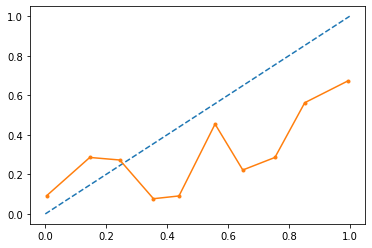

In [ ]:
calibration_curve_plot(probs_classes_lgb, y_exp)

Best Threshold=0.449239, G-Mean=0.787


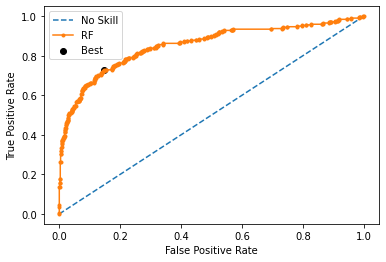

In [ ]:
threshold_roc = calibration_threshold_roc(probs_classes_lgb, y_exp)

In [ ]:
threshold_prc = calibration_threshold_prc(probs_classes_lgb, y_exp)

Best Threshold=0.977101, F-Score=0.684


## Statistics model calibrated - Choose the best calibration method before

In [ ]:
# Select the best threshold to distinguishthe classes
pred_lgb = (probs_classes_lgb[:, 1] > threshold_roc).astype(int)
# pred_lgb = (probs_classes[:, 1] > threshold_prc).astype(int)

In [ ]:
statistics = calc_statistics(y_exp, pred_lgb)

Accuracy =  0.8205741626794258
MCC =  0.5529802618114887
Kappa =  0.5505376344086022
Sensitivity =  0.7227414330218068
Specificity =  0.8542336548767417
Precision =  0.6304347826086957
PPV =  0.6304347826086957
NPV =  0.899548532731377
False positive rate =  0.1457663451232583
False negative rate =  0.2772585669781931
AUC =  0.7884875439492743
Classification error =  0.17942583732057416
Balanced accuracy =  0.7884875439492742
F1-score =  0.6734397677793904


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_lgb"

result_type = "calibrated"

metrics_lgb_calibrated = statistics
metrics_lgb_calibrated['model'] = model_type
metrics_lgb_calibrated['result_type'] = result_type
metrics_lgb_calibrated['calibration_threshold'] = threshold_roc
metrics_lgb_calibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,calibration_threshold
0,0.788488,0.722741,0.854234,0.630435,0.899549,0.550538,0.788488,0.55298,0.820574,0.179426,0.145766,0.277259,0.630435,0.67344,featmorgan_r2_2048_lgb,calibrated,0.449239


In [ ]:
# Saving the dataframe as excel file
#metrics_lgb.to_excel("/content/gdrive/MyDrive/scriptModels/results/model_binary_metrics_lgb_featmorgan_bee_mpro_newdata_gmean_NO_classweight_thres029.xlsx", sheet_name= "Sheet1")

## Statistics External Set Uncalibrated

In [ ]:
# Predict probabilities for the external set
probs_external = opt_lgb.predict_proba(x_ext)

In [ ]:
# Select the best threshold to distinguishthe classes
pred_lgb = (probs_external[:, 1] > 0.5).astype(int)
# pred_rf = (probs_classes[:, 1] > threshold_prc).astype(int)

In [ ]:
statistics = calc_statistics(y_ext, pred_lgb)

Accuracy =  0.8152866242038217
MCC =  0.5767373169512681
Kappa =  0.563805326690937
Sensitivity =  0.8125
Specificity =  0.8162393162393162
Precision =  0.6018518518518519
PPV =  0.6018518518518519
NPV =  0.9271844660194175
False positive rate =  0.18376068376068377
False negative rate =  0.1875
AUC =  0.8143696581196581
Classification error =  0.1847133757961783
Balanced accuracy =  0.8143696581196581
F1-score =  0.6914893617021277


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_lgb"

result_type = "uncalibrated_external_set"

metrics_lgb_graph_external_set_uncalibrated = statistics
metrics_lgb_graph_external_set_uncalibrated['model'] = model_type
metrics_lgb_graph_external_set_uncalibrated['result_type'] = result_type
metrics_lgb_graph_external_set_uncalibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type
0,0.81437,0.8125,0.816239,0.601852,0.927184,0.563805,0.81437,0.576737,0.815287,0.184713,0.183761,0.1875,0.601852,0.691489,featmorgan_r2_2048_lgb,uncalibrated_external_set


## Statistics external set calibrated

In [ ]:
# Select the best threshold to distinguishthe classes
pred_lgb = (probs_external[:, 1] > threshold_roc).astype(int)
# pred_rf = (probs_classes[:, 1] > threshold_prc).astype(int)

In [ ]:
statistics = calc_statistics(y_ext, pred_lgb)

Accuracy =  0.8121019108280255
MCC =  0.5715726105519356
Kappa =  0.5579153343196679
Sensitivity =  0.8125
Specificity =  0.811965811965812
Precision =  0.5963302752293578
PPV =  0.5963302752293578
NPV =  0.926829268292683
False positive rate =  0.18803418803418803
False negative rate =  0.1875
AUC =  0.8122329059829061
Classification error =  0.18789808917197448
Balanced accuracy =  0.812232905982906
F1-score =  0.6878306878306878


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_lgb"

result_type = "calibrated_external_set"

metrics_lgb_graph_external_set_calibrated = statistics
metrics_lgb_graph_external_set_calibrated['model'] = model_type
metrics_lgb_graph_external_set_calibrated['result_type'] = result_type
metrics_lgb_graph_external_set_calibrated['calibration_threshold'] = threshold_roc
metrics_lgb_graph_external_set_calibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,calibration_threshold
0,0.812233,0.8125,0.811966,0.59633,0.926829,0.557915,0.812233,0.571573,0.812102,0.187898,0.188034,0.1875,0.59633,0.687831,featmorgan_r2_2048_lgb,calibrated_external_set,0.449239


## Save model

In [ ]:
#Save model - pkl file
joblib.dump(opt_lgb, "/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/models/model_binary_lgb_featmorgan_r2_2048bits_gmean_gpmt_Mpro-postera-chemic50-ncats.pkl", compress=3)

['/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/models/model_binary_lgb_featmorgan_r2_2048bits_gmean_gpmt_Mpro-postera-chemic50-ncats.pkl']

## Compare all models

# Save an excell with all results - models uncalibrated

In [ ]:
frames = [metrics_rf_uncalibrated, metrics_rf_uncalibrated_ad, metrics_svm_uncalibrated,metrics_svm_uncalibrated_ad,
          metrics_lgb_uncalibrated, metrics_lgb_uncalibrated_ad,
          metrics_rf_calibrated, metrics_svm_calibrated, metrics_lgb_calibrated,
          metrics_rf_graph_external_set_uncalibrated, metrics_svm_graph_external_set_uncalibrated,
          metrics_lgb_graph_external_set_uncalibrated, metrics_rf_graph_external_set_calibrated,
          metrics_svm_graph_external_set_calibrated, metrics_lgb_graph_external_set_calibrated]

result = pd.concat(frames)

result = result.round(2)
result

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,coverage,calibration_threshold
0,0.69,0.40,0.98,0.90,0.83,0.47,0.69,0.53,0.84,0.16,0.02,0.60,0.90,0.56,featmorgan_r2_2048_rf,uncalibrated,NaN,NaN
0,0.75,0.52,0.98,0.90,0.83,0.57,0.75,0.60,0.84,0.16,0.02,0.48,0.90,0.66,featmorgan_r2_2048_rf_ad,uncalibrated,14.67,NaN
0,0.77,0.60,0.94,0.79,0.87,0.59,0.77,0.60,0.86,0.14,0.06,0.40,0.79,0.68,featmorgan_r2_2048_svm,uncalibrated,NaN,NaN
0,0.81,0.69,0.93,0.80,0.88,0.64,0.81,0.65,0.86,0.14,0.07,0.31,0.80,0.74,featmorgan_r2_2048_svm_ad,uncalibrated,14.67,NaN
0,0.79,0.72,0.86,0.64,0.90,0.56,0.79,0.56,0.82,0.18,0.14,0.28,0.64,0.68,featmorgan_r2_2048_lgb,uncalibrated,NaN,NaN
0,0.87,0.87,0.87,0.73,0.94,0.70,0.87,0.71,0.87,0.13,0.13,0.13,0.73,0.80,featmorgan_r2_2048_lgb_ad,uncalibrated,14.67,NaN
0,0.76,0.65,0.87,0.64,0.88,0.53,0.76,0.53,0.82,0.18,0.13,0.35,0.64,0.65,featmorgan_r2_2048_rf,calibrated,NaN,0.31
0,0.79,0.75,0.83,0.60,0.90,0.53,0.79,0.54,0.81,0.19,0.17,0.25,0.60,0.66,featmorgan_r2_2048_svm,calibrated,NaN,0.25
0,0.79,0.72,0.85,0.63,0.90,0.55,0.79,0.55,0.82,0.18,0.15,0.28,0.63,0.67,featmorgan_r2_2048_lgb,calibrated,NaN,0.45
0,0.71,0.44,0.97,0.85,0.84,0.49,0.71,0.53,0.84,0.16,0.03,0.56,0.85,0.58,featmorgan_r2_2048_rf,uncalibrated_external_set,NaN,NaN


In [ ]:
cols = result.columns.tolist()
cols = cols[-4:] + cols[:-4]
result = result[cols]
result

,model,result_type,coverage,calibration_threshold,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score
0,featmorgan_r2_2048_rf,uncalibrated,NaN,NaN,0.69,0.40,0.98,0.90,0.83,0.47,0.69,0.53,0.84,0.16,0.02,0.60,0.90,0.56
0,featmorgan_r2_2048_rf_ad,uncalibrated,14.67,NaN,0.75,0.52,0.98,0.90,0.83,0.57,0.75,0.60,0.84,0.16,0.02,0.48,0.90,0.66
0,featmorgan_r2_2048_svm,uncalibrated,NaN,NaN,0.77,0.60,0.94,0.79,0.87,0.59,0.77,0.60,0.86,0.14,0.06,0.40,0.79,0.68
0,featmorgan_r2_2048_svm_ad,uncalibrated,14.67,NaN,0.81,0.69,0.93,0.80,0.88,0.64,0.81,0.65,0.86,0.14,0.07,0.31,0.80,0.74
0,featmorgan_r2_2048_lgb,uncalibrated,NaN,NaN,0.79,0.72,0.86,0.64,0.90,0.56,0.79,0.56,0.82,0.18,0.14,0.28,0.64,0.68
0,featmorgan_r2_2048_lgb_ad,uncalibrated,14.67,NaN,0.87,0.87,0.87,0.73,0.94,0.70,0.87,0.71,0.87,0.13,0.13,0.13,0.73,0.80
0,featmorgan_r2_2048_rf,calibrated,NaN,0.31,0.76,0.65,0.87,0.64,0.88,0.53,0.76,0.53,0.82,0.18,0.13,0.35,0.64,0.65
0,featmorgan_r2_2048_svm,calibrated,NaN,0.25,0.79,0.75,0.83,0.60,0.90,0.53,0.79,0.54,0.81,0.19,0.17,0.25,0.60,0.66
0,featmorgan_r2_2048_lgb,calibrated,NaN,0.45,0.79,0.72,0.85,0.63,0.90,0.55,0.79,0.55,0.82,0.18,0.15,0.28,0.63,0.67
0,featmorgan_r2_2048_rf,uncalibrated_external_set,NaN,NaN,0.71,0.44,0.97,0.85,0.84,0.49,0.71,0.53,0.84,0.16,0.03,0.56,0.85,0.58


In [ ]:
# Saving the dataframe as excel file
result.to_excel("/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/results/metrics_binary_featmorgan_r2_2048bits_allmodels_gpmt_Mpro-postera-chemic50-ncats.xlsx", sheet_name= "Sheet1")

# RUN WITH SMOTE OVER-SAMPLING

# External Set

In [ ]:
#randomly select 20% of compounds as external set
X, X_ext, Y, Y_ext = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

In [ ]:
X_check = pd.DataFrame(X)
Y_check = pd.DataFrame(Y)
print("Number of compounds and descriptors in training set:", X_check.shape)
print("Number of compounds and target variables in training set:", Y_check.shape)

Number of compounds and descriptors in training set: (1254, 2048)
Number of compounds and target variables in training set: (1254, 1)


In [ ]:
X_ext_check = pd.DataFrame(X_ext)
Y_ext_check = pd.DataFrame(Y_ext)

print("Number of compounds and descriptors in external set:", X_ext_check.shape)
print("Number of compounds and target variables in external set:", Y_ext_check.shape)

Number of compounds and descriptors in external set: (314, 2048)
Number of compounds and target variables in external set: (314, 1)


# Data splitting with SMOTE

In [ ]:
#rebalancing using SMOTE
X_resampled, Y_resampled = SMOTE().fit_resample(X, Y)

In [ ]:
from collections import Counter
print(sorted(Counter(Y_resampled).items()))

[(0, 933), (1, 933)]


In [ ]:
Y_resampled = np.hstack(Y_resampled)

In [ ]:
print(X_resampled.shape)
print(Y_resampled.shape)
print(sum(Y_resampled)/len(Y_resampled))

(1866, 2048)
(1866,)
0.5


In [ ]:
#Create folds for cross-validation
#cv = StratifiedKFold(n_splits=5, shuffle=False, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=False)

# RF Model building - Bayesian hyperparameter search with SMOTE

In [ ]:
scorer = make_scorer(geometric_mean_score)

# log-uniform: understand as search over p = exp(x) by varying x
opt_rf = BayesSearchCV(
    RandomForestClassifier(),
    {'max_features': ['auto', 'sqrt'],
    'n_estimators': [100, 1000],
    "max_depth": [2, 100],
    'min_samples_leaf': [1,20],
    'min_samples_split': [2, 20]
    },
    n_iter=1, # Number of parameter settings that are sampled
    cv=cv,
    scoring = scorer,
    verbose=0,
    refit= True, # Refit the best estimator with the entire dataset.
    random_state=42,
    n_jobs = -1
)

opt_rf.fit(X_resampled, Y_resampled)

print("Best parameters: %s" % opt_rf.best_params_)

Best parameters: OrderedDict([('max_depth', 42), ('max_features', 'sqrt'), ('min_samples_leaf', 19), ('min_samples_split', 8), ('n_estimators', 703)])


## Check performance of each fold

In [ ]:
pred_rf, Y_exp, probs_classes_rf, AD_fold, Y_pred_ad, Y_exp_ad = cros_val(X_resampled,Y_resampled, RandomForestClassifier(**opt_rf.best_params_))

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


IndexError: ignored

## Statistics - featmorgan-RF

In [ ]:
statistics = calc_statistics(y_exp, pred_rf)

Accuracy =  0.835725677830941
MCC =  0.5307495160674757
Kappa =  0.47417530746589487
Sensitivity =  0.40498442367601245
Specificity =  0.9839228295819936
Precision =  0.896551724137931
PPV =  0.896551724137931
NPV =  0.8277727682596934
False positive rate =  0.01607717041800643
False negative rate =  0.5950155763239875
AUC =  0.6944536266290031
Classification error =  0.16427432216905902
Balanced accuracy =  0.694453626629003
F1-score =  0.5579399141630901


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_rf"

result_type = "uncalibrated"

metrics_rf_uncalibrated = statistics
metrics_rf_uncalibrated['model'] = model_type
metrics_rf_uncalibrated['result_type'] = result_type
metrics_rf_uncalibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type
0,0.694454,0.404984,0.983923,0.896552,0.827773,0.474175,0.694454,0.53075,0.835726,0.164274,0.016077,0.595016,0.896552,0.55794,featmorgan_r2_2048_rf,uncalibrated


In [ ]:
statistics_ad = calc_statistics(y_exp_ad, y_pred_ad)

Accuracy =  0.842391304347826
MCC =  0.6027461697688017
Kappa =  0.5658965180605271
Sensitivity =  0.5185185185185185
Specificity =  0.9769230769230769
Precision =  0.9032258064516129
PPV =  0.9032258064516129
NPV =  0.8300653594771242
False positive rate =  0.023076923076923078
False negative rate =  0.48148148148148145
AUC =  0.7477207977207977
Classification error =  0.15760869565217395
Balanced accuracy =  0.7477207977207977
F1-score =  0.6588235294117647


In [ ]:
coverage = (len(y_exp_ad)/len(y_exp))*100
coverage

14.673046251993622

In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_rf_ad"

result_type = "uncalibrated"

metrics_rf_uncalibrated_ad = statistics_ad
metrics_rf_uncalibrated_ad['model'] = model_type
metrics_rf_uncalibrated_ad['result_type'] = result_type
metrics_rf_uncalibrated_ad['coverage'] = coverage
metrics_rf_uncalibrated_ad

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,coverage
0,0.747721,0.518519,0.976923,0.903226,0.830065,0.565897,0.747721,0.602746,0.842391,0.157609,0.023077,0.481481,0.903226,0.658824,featmorgan_r2_2048_rf_ad,uncalibrated,14.673046


### Check model calibatrion

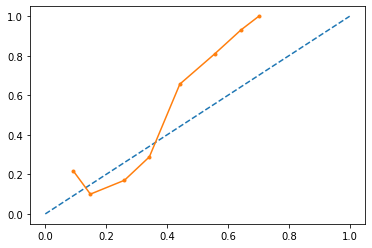

In [ ]:
calibration_curve_plot(probs_classes_rf, y_exp)

### Use ROC-Curve and Gmean to select a threshold for calibration

Best Threshold=0.312331, G-Mean=0.758


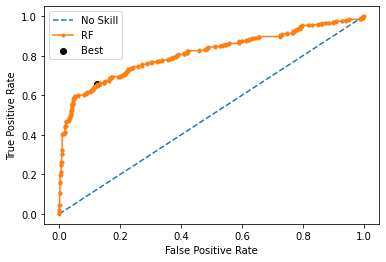

In [ ]:
threshold_roc = calibration_threshold_roc(probs_classes_rf, y_exp)

In [ ]:
threshold_prc = calibration_threshold_prc(probs_classes_rf, y_exp)

Best Threshold=0.380510, F-Score=0.683


## Statistics model calibrated - Choose the best calibration method before

In [ ]:
# Select the best threshold to distinguishthe classes
pred_rf = (probs_classes_rf[:, 1] > threshold_roc).astype(int)
# pred_rf = (probs_classes[:, 1] > threshold_prc).astype(int)

In [ ]:
statistics = calc_statistics(y_exp, pred_rf)

Accuracy =  0.8181818181818182
MCC =  0.5256226385417837
Kappa =  0.5255816731877782
Sensitivity =  0.6542056074766355
Specificity =  0.8745980707395499
Precision =  0.6422018348623854
PPV =  0.6422018348623854
NPV =  0.8802588996763754
False positive rate =  0.12540192926045016
False negative rate =  0.34579439252336447
AUC =  0.7644018391080926
Classification error =  0.18181818181818177
Balanced accuracy =  0.7644018391080927
F1-score =  0.6481481481481481


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_rf"

result_type = "calibrated"

metrics_rf_calibrated = statistics
metrics_rf_calibrated['model'] = model_type
metrics_rf_calibrated['result_type'] = result_type
metrics_rf_calibrated['calibration_threshold'] = threshold_roc
metrics_rf_calibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,calibration_threshold
0,0.764402,0.654206,0.874598,0.642202,0.880259,0.525582,0.764402,0.525623,0.818182,0.181818,0.125402,0.345794,0.642202,0.648148,featmorgan_r2_2048_rf,calibrated,0.312331


## Statistics External Set Uncalibrated

In [ ]:
# Predict probabilities for the external set
probs_external = opt_rf.predict_proba(x_ext)
len(probs_external)

314

In [ ]:
# Select the best threshold to distinguishthe classes
pred_rf = (probs_external[:, 1] > 0.5).astype(int)
# pred_rf = (probs_classes[:, 1] > threshold_prc).astype(int)
len(pred_rf)

314

In [ ]:
statistics = calc_statistics(y_ext, pred_rf)

Accuracy =  0.8375796178343949
MCC =  0.532633164010211
Kappa =  0.49055163199083796
Sensitivity =  0.4375
Specificity =  0.9743589743589743
Precision =  0.8536585365853658
PPV =  0.8536585365853658
NPV =  0.8351648351648352
False positive rate =  0.02564102564102564
False negative rate =  0.5625
AUC =  0.7059294871794871
Classification error =  0.16242038216560506
Balanced accuracy =  0.7059294871794872
F1-score =  0.578512396694215


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_rf"

result_type = "uncalibrated_external_set"

metrics_rf_graph_external_set_uncalibrated = statistics
metrics_rf_graph_external_set_uncalibrated['model'] = model_type
metrics_rf_graph_external_set_uncalibrated['result_type'] = result_type
metrics_rf_graph_external_set_uncalibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type
0,0.705929,0.4375,0.974359,0.853659,0.835165,0.490552,0.705929,0.532633,0.83758,0.16242,0.025641,0.5625,0.853659,0.578512,featmorgan_r2_2048_rf,uncalibrated_external_set


## Statistics External Set Calibrated

In [ ]:
# Select the best threshold to distinguishthe classes
pred_rf = (probs_external[:, 1] > threshold_roc).astype(int)
# pred_rf = (probs_classes[:, 1] > threshold_prc).astype(int)

In [ ]:
statistics = calc_statistics(y_ext, pred_rf)

Accuracy =  0.8407643312101911
MCC =  0.5708117188057883
Kappa =  0.5700514842808632
Sensitivity =  0.65
Specificity =  0.905982905982906
Precision =  0.7027027027027027
PPV =  0.7027027027027027
NPV =  0.8833333333333333
False positive rate =  0.09401709401709402
False negative rate =  0.35
AUC =  0.777991452991453
Classification error =  0.15923566878980888
Balanced accuracy =  0.777991452991453
F1-score =  0.6753246753246753


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_rf"

result_type = "calibrated_external_set"

metrics_rf_graph_external_set_calibrated = statistics
metrics_rf_graph_external_set_calibrated['model'] = model_type
metrics_rf_graph_external_set_calibrated['result_type'] = result_type
metrics_rf_graph_external_set_calibrated['calibration_threshold']= threshold_roc


## Save model

In [ ]:
#Save model - pkl file
joblib.dump(opt_rf, "/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/models/model_binary_rf_featmorgan_r2_2048bits_gmean_gpmt_Mpro-postera-chemic50-ncats.pkl", compress=3)

['/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/models/model_binary_rf_featmorgan_r2_2048bits_gmean_gpmt_Mpro-postera-chemic50-ncats.pkl']

# SVM Model building - Bayesian hyperparameter search with SMOTE

In [ ]:
scorer = make_scorer(geometric_mean_score)

# log-uniform: understand as search over p = exp(x) by varying x
opt_svm = BayesSearchCV(
    SVC(probability=True),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'kernel': ['rbf'],  # categorical parameter | ['linear', 'poly', 'rbf'] to test all kernels
    },
    n_iter=30, # Number of parameter settings that are sampled
    cv=cv,
    scoring = scorer,
    refit = True, # Refit the best estimator with the entire dataset.
    random_state=42,
    n_jobs = -1
)

opt_svm.fit(x, y)

print("Best parameters: %s" % opt_svm.best_params_)

Best parameters: OrderedDict([('C', 493.8229567443732), ('gamma', 0.009358853865395231), ('kernel', 'rbf')])


## Check performance of each fold

In [ ]:
pred_svm, y_exp, probs_classes_svm, AD_fold, y_pred_ad, y_exp_ad = cros_val(x,y, SVC(**opt_svm.best_params_, probability=True))

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:187

Balanced accuracy (fold 1) =  0.7752757352941176
Balanced accuracy (fold 2) =  0.7726019385026738
Balanced accuracy (fold 3) =  0.7623245320855615
Balanced accuracy (fold 4) =  0.7373449131513647
Balanced accuracy (fold 5) =  0.8168682795698925


In [ ]:
statistics = calc_statistics(y_exp, pred_svm)

Accuracy =  0.8564593301435407
MCC =  0.6004390839568042
Kappa =  0.5914377871175839
Sensitivity =  0.6012461059190031
Specificity =  0.9442658092175777
Precision =  0.7877551020408163
PPV =  0.7877551020408163
NPV =  0.8731417244796829
False positive rate =  0.055734190782422297
False negative rate =  0.3987538940809969
AUC =  0.7727559575682904
Classification error =  0.1435406698564593
Balanced accuracy =  0.7727559575682904
F1-score =  0.6819787985865723


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_svm"

result_type = "uncalibrated"

metrics_svm_uncalibrated = statistics
metrics_svm_uncalibrated['model'] = model_type
metrics_svm_uncalibrated['result_type'] = result_type
metrics_svm_uncalibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type
0,0.772756,0.601246,0.944266,0.787755,0.873142,0.591438,0.772756,0.600439,0.856459,0.143541,0.055734,0.398754,0.787755,0.681979,featmorgan_r2_2048_svm,uncalibrated


In [ ]:
statistics_ad = calc_statistics(y_exp_ad, y_pred_ad)

Accuracy =  0.8586956521739131
MCC =  0.6477369472991997
Kappa =  0.6438356164383562
Sensitivity =  0.6851851851851852
Specificity =  0.9307692307692308
Precision =  0.8043478260869565
PPV =  0.8043478260869565
NPV =  0.8768115942028986
False positive rate =  0.06923076923076923
False negative rate =  0.3148148148148148
AUC =  0.807977207977208
Classification error =  0.14130434782608692
Balanced accuracy =  0.8079772079772081
F1-score =  0.74


In [ ]:
coverage = (len(y_exp_ad)/len(y_exp))*100
coverage

14.673046251993622

In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_svm_ad"

result_type = "uncalibrated"

metrics_svm_uncalibrated_ad = statistics_ad
metrics_svm_uncalibrated_ad['model'] = model_type
metrics_svm_uncalibrated_ad['result_type'] = result_type
metrics_svm_uncalibrated_ad['coverage'] = coverage
metrics_svm_uncalibrated_ad

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,coverage
0,0.807977,0.685185,0.930769,0.804348,0.876812,0.643836,0.807977,0.647737,0.858696,0.141304,0.069231,0.314815,0.804348,0.74,featmorgan_r2_2048_svm_ad,uncalibrated,14.673046


## Check model calibatrion

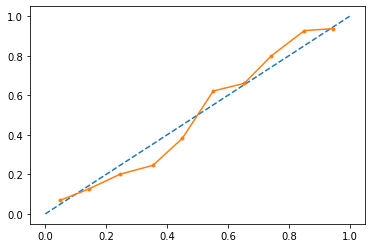

In [ ]:
calibration_curve_plot(probs_classes_svm, y_exp)

Best Threshold=0.252505, G-Mean=0.787


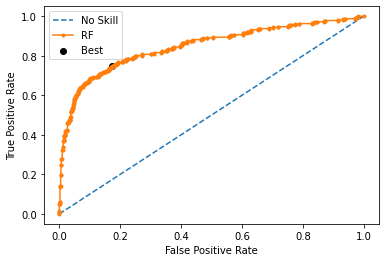

In [ ]:
threshold_roc = calibration_threshold_roc(probs_classes_svm, y_exp)

In [ ]:
threshold_prc = calibration_threshold_prc(probs_classes_svm, y_exp)

Best Threshold=0.453424, F-Score=0.696


## Statistics model calibrated - Choose the best calibration method before

In [ ]:
# Select the best threshold to distinguishthe classes
pred_svm = (probs_classes_svm[:, 1] > threshold_roc).astype(int)
# pred_svm = (probs_classes[:, 1] > threshold_prc).astype(int)

In [ ]:
statistics = calc_statistics(y_exp, pred_svm)

Accuracy =  0.8054226475279107
MCC =  0.5354254985036573
Kappa =  0.5286658348352511
Sensitivity =  0.7476635514018691
Specificity =  0.8252947481243301
Precision =  0.5955334987593052
PPV =  0.5955334987593052
NPV =  0.9048178613396005
False positive rate =  0.17470525187566988
False negative rate =  0.2523364485981308
AUC =  0.7864791497630997
Classification error =  0.1945773524720893
Balanced accuracy =  0.7864791497630996
F1-score =  0.6629834254143646


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_svm"

result_type = "calibrated"

metrics_svm_calibrated = statistics
metrics_svm_calibrated['model'] = model_type
metrics_svm_calibrated['result_type'] = result_type
metrics_svm_calibrated['calibration_threshold'] = threshold_roc
metrics_svm_calibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,calibration_threshold
0,0.786479,0.747664,0.825295,0.595533,0.904818,0.528666,0.786479,0.535425,0.805423,0.194577,0.174705,0.252336,0.595533,0.662983,featmorgan_r2_2048_svm,calibrated,0.252505


In [ ]:
# Saving the dataframe as excel file
#metrics_svm.to_excel("/content/gdrive/MyDrive/scriptModels/results/model_binary_metrics_svm_featmorgan_r2_gmean_mpro_newdata_thres039.xlsx", sheet_name= "Sheet1")

## Statistics External Set Uncalibrated

In [ ]:
# Predict probabilities for the external set
probs_external = opt_svm.predict_proba(x_ext)

In [ ]:
# Select the best threshold to distinguishthe classes
pred_svm = (probs_external[:, 1] > 0.5).astype(int)
# pred_rf = (probs_classes[:, 1] > threshold_prc).astype(int)

In [ ]:
statistics = calc_statistics(y_ext, pred_svm)

Accuracy =  0.8694267515923567
MCC =  0.6547461699707879
Kappa =  0.6547229523145417
Sensitivity =  0.7375
Specificity =  0.9145299145299145
Precision =  0.7468354430379747
PPV =  0.7468354430379747
NPV =  0.9106382978723404
False positive rate =  0.08547008547008547
False negative rate =  0.2625
AUC =  0.8260149572649572
Classification error =  0.13057324840764328
Balanced accuracy =  0.8260149572649573
F1-score =  0.7421383647798743


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_svm"

result_type = "uncalibrated_external_set"

metrics_svm_graph_external_set_uncalibrated = statistics
metrics_svm_graph_external_set_uncalibrated['model'] = model_type
metrics_svm_graph_external_set_uncalibrated['result_type'] = result_type
metrics_svm_graph_external_set_uncalibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type
0,0.826015,0.7375,0.91453,0.746835,0.910638,0.654723,0.826015,0.654746,0.869427,0.130573,0.08547,0.2625,0.746835,0.742138,featmorgan_r2_2048_svm,uncalibrated_external_set


## Statistics External Set Calibrated

In [ ]:
# Select the best threshold to distinguishthe classes
pred_svm = (probs_external[:, 1] > threshold_roc).astype(int)
# pred_rf = (probs_classes[:, 1] > threshold_prc).astype(int)

In [ ]:
statistics = calc_statistics(y_ext, pred_svm)

Accuracy =  0.8152866242038217
MCC =  0.5868909423962707
Kappa =  0.5701472809667674
Sensitivity =  0.8375
Specificity =  0.8076923076923077
Precision =  0.5982142857142857
PPV =  0.5982142857142857
NPV =  0.9356435643564357
False positive rate =  0.19230769230769232
False negative rate =  0.1625
AUC =  0.8225961538461538
Classification error =  0.1847133757961783
Balanced accuracy =  0.8225961538461539
F1-score =  0.6979166666666667


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_svm"

result_type = "calibrated_external_set"

metrics_svm_graph_external_set_calibrated = statistics
metrics_svm_graph_external_set_calibrated['model'] = model_type
metrics_svm_graph_external_set_calibrated['result_type'] = result_type
metrics_svm_graph_external_set_calibrated['calibration_threshold'] = threshold_roc
metrics_svm_graph_external_set_calibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,calibration_threshold
0,0.822596,0.8375,0.807692,0.598214,0.935644,0.570147,0.822596,0.586891,0.815287,0.184713,0.192308,0.1625,0.598214,0.697917,featmorgan_r2_2048_svm,calibrated_external_set,0.252505


## Save model

In [ ]:
#Save model - pkl file
joblib.dump(opt_svm, "/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/models/model_binary_svm_featmorgan_r2_2048bits_gmean_gpmt_Mpro-postera-chemic50-ncats.pkl", compress=3)

['/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/models/model_binary_svm_featmorgan_r2_2048bits_gmean_gpmt_Mpro-postera-chemic50-ncats.pkl']

# LightGBM Model building - Bayesian hyperparameter search with SMOTE

In [ ]:
scorer = make_scorer(geometric_mean_score)

# log-uniform: understand as search over p = exp(x) by varying x
opt_lgb = BayesSearchCV(lgb.LGBMClassifier(),
                        {'learning_rate': (0.01, 1.0, 'log-uniform'),
                         'num_leaves': (7, 4095),
                         'n_estimators': (100, 800),
                         'max_depth': (2, 63),
                         'subsample': (0.4, 1),
                         'scale_pos_weight': (1, 1000)},
                        n_iter = 30, # Number of parameter settings that are sampled
                        cv = cv,
                        scoring = scorer,
                        refit = True, # Refit the best estimator with the entire dataset.
                        verbose = 0,
                        random_state = 42,
                        n_jobs = 1)

opt_lgb.fit(x, y)

print("Best parameters: %s" % opt_lgb.best_params_)

A saída de streaming foi truncada nas últimas 5000 linhas.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

## Check performance of each fold

In [ ]:
pred_lgb, y_exp, probs_classes_lgb, AD_fold, y_pred_ad, y_exp_ad = cros_val(x,y, lgb.LGBMClassifier(**opt_lgb.best_params_,))

[LightGBM] [Info] Number of positive: 257, number of negative: 746
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 1003, number of used features: 256
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.256231 -> initscore=-1.065650
[LightGBM] [Info] Start training from score -1.065650
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


[LightGBM] [Info] Number of positive: 257, number of negative: 746
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 1003, number of used features: 257
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.256231 -> initscore=-1.065650
[LightGBM] [Info] Start training from score -1.065650
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


[LightGBM] [Info] Number of positive: 257, number of negative: 746
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 1003, number of used features: 259
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.256231 -> initscore=-1.065650
[LightGBM] [Info] Start training from score -1.065650
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


[LightGBM] [Info] Number of positive: 256, number of negative: 747
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 1003, number of used features: 256
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.255234 -> initscore=-1.070888
[LightGBM] [Info] Start training from score -1.070888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


[LightGBM] [Info] Number of positive: 257, number of negative: 747
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 1004, number of used features: 261
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.255976 -> initscore=-1.066989
[LightGBM] [Info] Start training from score -1.066989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)


Balanced accuracy (fold 1) =  0.8315925802139037
Balanced accuracy (fold 2) =  0.8054812834224598
Balanced accuracy (fold 3) =  0.7742312834224598
Balanced accuracy (fold 4) =  0.7458643507030605
Balanced accuracy (fold 5) =  0.7941028225806452


## Statistics - featmorgan-LGB

In [ ]:
statistics = calc_statistics(y_exp, pred_lgb)

Accuracy =  0.8229665071770335
MCC =  0.5573996032257912
Kappa =  0.5552296321858914
Sensitivity =  0.7227414330218068
Specificity =  0.857449088960343
Precision =  0.6356164383561644
PPV =  0.6356164383561644
NPV =  0.8998875140607424
False positive rate =  0.14255091103965703
False negative rate =  0.2772585669781931
AUC =  0.790095260991075
Classification error =  0.17703349282296654
Balanced accuracy =  0.790095260991075
F1-score =  0.6763848396501457


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_lgb"

result_type = "uncalibrated"

metrics_lgb_uncalibrated = statistics
metrics_lgb_uncalibrated['model'] = model_type
metrics_lgb_uncalibrated['result_type'] = result_type
metrics_lgb_uncalibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type
0,0.790095,0.722741,0.857449,0.635616,0.899888,0.55523,0.790095,0.5574,0.822967,0.177033,0.142551,0.277259,0.635616,0.676385,featmorgan_r2_2048_lgb,uncalibrated


In [ ]:
statistics_ad = calc_statistics(y_exp_ad, y_pred_ad)
coverage = (len(y_exp_ad)/len(y_exp))*100
coverage

Accuracy =  0.8695652173913043
MCC =  0.7071076205815636
Kappa =  0.7016216216216216
Sensitivity =  0.8703703703703703
Specificity =  0.8692307692307693
Precision =  0.734375
PPV =  0.734375
NPV =  0.9416666666666667
False positive rate =  0.13076923076923078
False negative rate =  0.12962962962962962
AUC =  0.8698005698005697
Classification error =  0.13043478260869568
Balanced accuracy =  0.8698005698005697
F1-score =  0.7966101694915254


14.673046251993622

In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_lgb_ad"

result_type = "uncalibrated"

metrics_lgb_uncalibrated_ad = statistics_ad
metrics_lgb_uncalibrated_ad['model'] = model_type
metrics_lgb_uncalibrated_ad['result_type'] = result_type
metrics_lgb_uncalibrated_ad['coverage'] = coverage
metrics_lgb_uncalibrated_ad

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,coverage
0,0.869801,0.87037,0.869231,0.734375,0.941667,0.701622,0.869801,0.707108,0.869565,0.130435,0.130769,0.12963,0.734375,0.79661,featmorgan_r2_2048_lgb_ad,uncalibrated,14.673046


## Check model calibatrion

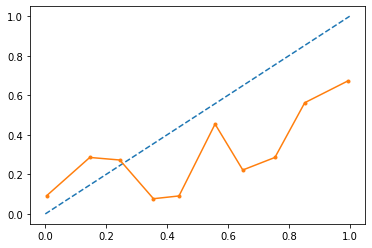

In [ ]:
calibration_curve_plot(probs_classes_lgb, y_exp)

Best Threshold=0.449239, G-Mean=0.787


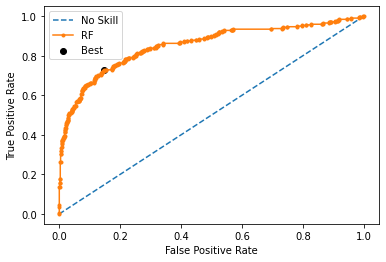

In [ ]:
threshold_roc = calibration_threshold_roc(probs_classes_lgb, y_exp)

In [ ]:
threshold_prc = calibration_threshold_prc(probs_classes_lgb, y_exp)

Best Threshold=0.977101, F-Score=0.684


## Statistics model calibrated - Choose the best calibration method before

In [ ]:
# Select the best threshold to distinguishthe classes
pred_lgb = (probs_classes_lgb[:, 1] > threshold_roc).astype(int)
# pred_lgb = (probs_classes[:, 1] > threshold_prc).astype(int)

In [ ]:
statistics = calc_statistics(y_exp, pred_lgb)

Accuracy =  0.8205741626794258
MCC =  0.5529802618114887
Kappa =  0.5505376344086022
Sensitivity =  0.7227414330218068
Specificity =  0.8542336548767417
Precision =  0.6304347826086957
PPV =  0.6304347826086957
NPV =  0.899548532731377
False positive rate =  0.1457663451232583
False negative rate =  0.2772585669781931
AUC =  0.7884875439492743
Classification error =  0.17942583732057416
Balanced accuracy =  0.7884875439492742
F1-score =  0.6734397677793904


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_lgb"

result_type = "calibrated"

metrics_lgb_calibrated = statistics
metrics_lgb_calibrated['model'] = model_type
metrics_lgb_calibrated['result_type'] = result_type
metrics_lgb_calibrated['calibration_threshold'] = threshold_roc
metrics_lgb_calibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,calibration_threshold
0,0.788488,0.722741,0.854234,0.630435,0.899549,0.550538,0.788488,0.55298,0.820574,0.179426,0.145766,0.277259,0.630435,0.67344,featmorgan_r2_2048_lgb,calibrated,0.449239


In [ ]:
# Saving the dataframe as excel file
#metrics_lgb.to_excel("/content/gdrive/MyDrive/scriptModels/results/model_binary_metrics_lgb_featmorgan_bee_mpro_newdata_gmean_NO_classweight_thres029.xlsx", sheet_name= "Sheet1")

## Statistics External Set Uncalibrated

In [ ]:
# Predict probabilities for the external set
probs_external = opt_lgb.predict_proba(x_ext)

In [ ]:
# Select the best threshold to distinguishthe classes
pred_lgb = (probs_external[:, 1] > 0.5).astype(int)
# pred_rf = (probs_classes[:, 1] > threshold_prc).astype(int)

In [ ]:
statistics = calc_statistics(y_ext, pred_lgb)

Accuracy =  0.8152866242038217
MCC =  0.5767373169512681
Kappa =  0.563805326690937
Sensitivity =  0.8125
Specificity =  0.8162393162393162
Precision =  0.6018518518518519
PPV =  0.6018518518518519
NPV =  0.9271844660194175
False positive rate =  0.18376068376068377
False negative rate =  0.1875
AUC =  0.8143696581196581
Classification error =  0.1847133757961783
Balanced accuracy =  0.8143696581196581
F1-score =  0.6914893617021277


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_lgb"

result_type = "uncalibrated_external_set"

metrics_lgb_graph_external_set_uncalibrated = statistics
metrics_lgb_graph_external_set_uncalibrated['model'] = model_type
metrics_lgb_graph_external_set_uncalibrated['result_type'] = result_type
metrics_lgb_graph_external_set_uncalibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type
0,0.81437,0.8125,0.816239,0.601852,0.927184,0.563805,0.81437,0.576737,0.815287,0.184713,0.183761,0.1875,0.601852,0.691489,featmorgan_r2_2048_lgb,uncalibrated_external_set


## Statistics external set calibrated

In [ ]:
# Select the best threshold to distinguishthe classes
pred_lgb = (probs_external[:, 1] > threshold_roc).astype(int)
# pred_rf = (probs_classes[:, 1] > threshold_prc).astype(int)

In [ ]:
statistics = calc_statistics(y_ext, pred_lgb)

Accuracy =  0.8121019108280255
MCC =  0.5715726105519356
Kappa =  0.5579153343196679
Sensitivity =  0.8125
Specificity =  0.811965811965812
Precision =  0.5963302752293578
PPV =  0.5963302752293578
NPV =  0.926829268292683
False positive rate =  0.18803418803418803
False negative rate =  0.1875
AUC =  0.8122329059829061
Classification error =  0.18789808917197448
Balanced accuracy =  0.812232905982906
F1-score =  0.6878306878306878


In [ ]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_lgb"

result_type = "calibrated_external_set"

metrics_lgb_graph_external_set_calibrated = statistics
metrics_lgb_graph_external_set_calibrated['model'] = model_type
metrics_lgb_graph_external_set_calibrated['result_type'] = result_type
metrics_lgb_graph_external_set_calibrated['calibration_threshold'] = threshold_roc
metrics_lgb_graph_external_set_calibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,calibration_threshold
0,0.812233,0.8125,0.811966,0.59633,0.926829,0.557915,0.812233,0.571573,0.812102,0.187898,0.188034,0.1875,0.59633,0.687831,featmorgan_r2_2048_lgb,calibrated_external_set,0.449239


## Save model

In [ ]:
#Save model - pkl file
joblib.dump(opt_lgb, "/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/models/model_binary_lgb_featmorgan_r2_2048bits_gmean_gpmt_Mpro-postera-chemic50-ncats.pkl", compress=3)

['/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/models/model_binary_lgb_featmorgan_r2_2048bits_gmean_gpmt_Mpro-postera-chemic50-ncats.pkl']

## Compare all models

# Save an excell with all results - models uncalibrated with SMOTE

In [ ]:
frames = [metrics_rf_uncalibrated, metrics_rf_uncalibrated_ad, metrics_svm_uncalibrated,metrics_svm_uncalibrated_ad,
          metrics_lgb_uncalibrated, metrics_lgb_uncalibrated_ad,
          metrics_rf_calibrated, metrics_svm_calibrated, metrics_lgb_calibrated,
          metrics_rf_graph_external_set_uncalibrated, metrics_svm_graph_external_set_uncalibrated,
          metrics_lgb_graph_external_set_uncalibrated, metrics_rf_graph_external_set_calibrated,
          metrics_svm_graph_external_set_calibrated, metrics_lgb_graph_external_set_calibrated]

result = pd.concat(frames)

result = result.round(2)
result

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,coverage,calibration_threshold
0,0.69,0.40,0.98,0.90,0.83,0.47,0.69,0.53,0.84,0.16,0.02,0.60,0.90,0.56,featmorgan_r2_2048_rf,uncalibrated,NaN,NaN
0,0.75,0.52,0.98,0.90,0.83,0.57,0.75,0.60,0.84,0.16,0.02,0.48,0.90,0.66,featmorgan_r2_2048_rf_ad,uncalibrated,14.67,NaN
0,0.77,0.60,0.94,0.79,0.87,0.59,0.77,0.60,0.86,0.14,0.06,0.40,0.79,0.68,featmorgan_r2_2048_svm,uncalibrated,NaN,NaN
0,0.81,0.69,0.93,0.80,0.88,0.64,0.81,0.65,0.86,0.14,0.07,0.31,0.80,0.74,featmorgan_r2_2048_svm_ad,uncalibrated,14.67,NaN
0,0.79,0.72,0.86,0.64,0.90,0.56,0.79,0.56,0.82,0.18,0.14,0.28,0.64,0.68,featmorgan_r2_2048_lgb,uncalibrated,NaN,NaN
0,0.87,0.87,0.87,0.73,0.94,0.70,0.87,0.71,0.87,0.13,0.13,0.13,0.73,0.80,featmorgan_r2_2048_lgb_ad,uncalibrated,14.67,NaN
0,0.76,0.65,0.87,0.64,0.88,0.53,0.76,0.53,0.82,0.18,0.13,0.35,0.64,0.65,featmorgan_r2_2048_rf,calibrated,NaN,0.31
0,0.79,0.75,0.83,0.60,0.90,0.53,0.79,0.54,0.81,0.19,0.17,0.25,0.60,0.66,featmorgan_r2_2048_svm,calibrated,NaN,0.25
0,0.79,0.72,0.85,0.63,0.90,0.55,0.79,0.55,0.82,0.18,0.15,0.28,0.63,0.67,featmorgan_r2_2048_lgb,calibrated,NaN,0.45
0,0.71,0.44,0.97,0.85,0.84,0.49,0.71,0.53,0.84,0.16,0.03,0.56,0.85,0.58,featmorgan_r2_2048_rf,uncalibrated_external_set,NaN,NaN


In [ ]:
cols = result.columns.tolist()
cols = cols[-4:] + cols[:-4]
result = result[cols]
result

,model,result_type,coverage,calibration_threshold,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score
0,featmorgan_r2_2048_rf,uncalibrated,NaN,NaN,0.69,0.40,0.98,0.90,0.83,0.47,0.69,0.53,0.84,0.16,0.02,0.60,0.90,0.56
0,featmorgan_r2_2048_rf_ad,uncalibrated,14.67,NaN,0.75,0.52,0.98,0.90,0.83,0.57,0.75,0.60,0.84,0.16,0.02,0.48,0.90,0.66
0,featmorgan_r2_2048_svm,uncalibrated,NaN,NaN,0.77,0.60,0.94,0.79,0.87,0.59,0.77,0.60,0.86,0.14,0.06,0.40,0.79,0.68
0,featmorgan_r2_2048_svm_ad,uncalibrated,14.67,NaN,0.81,0.69,0.93,0.80,0.88,0.64,0.81,0.65,0.86,0.14,0.07,0.31,0.80,0.74
0,featmorgan_r2_2048_lgb,uncalibrated,NaN,NaN,0.79,0.72,0.86,0.64,0.90,0.56,0.79,0.56,0.82,0.18,0.14,0.28,0.64,0.68
0,featmorgan_r2_2048_lgb_ad,uncalibrated,14.67,NaN,0.87,0.87,0.87,0.73,0.94,0.70,0.87,0.71,0.87,0.13,0.13,0.13,0.73,0.80
0,featmorgan_r2_2048_rf,calibrated,NaN,0.31,0.76,0.65,0.87,0.64,0.88,0.53,0.76,0.53,0.82,0.18,0.13,0.35,0.64,0.65
0,featmorgan_r2_2048_svm,calibrated,NaN,0.25,0.79,0.75,0.83,0.60,0.90,0.53,0.79,0.54,0.81,0.19,0.17,0.25,0.60,0.66
0,featmorgan_r2_2048_lgb,calibrated,NaN,0.45,0.79,0.72,0.85,0.63,0.90,0.55,0.79,0.55,0.82,0.18,0.15,0.28,0.63,0.67
0,featmorgan_r2_2048_rf,uncalibrated_external_set,NaN,NaN,0.71,0.44,0.97,0.85,0.84,0.49,0.71,0.53,0.84,0.16,0.03,0.56,0.85,0.58


In [ ]:
# Saving the dataframe as excel file
result.to_excel("/content/gdrive/MyDrive/Colab_Notebooks/scriptModels/results/metrics_binary_featmorgan_r2_2048bits_allmodels_gpmt_Mpro-postera-chemic50-ncats.xlsx", sheet_name= "Sheet1")